# Homework 2: Geospatial Analysis
### Madison Enda 05/13/2025

1. Using the CMIP6 database hosted on Amazon Web Services, choose any two models you
like: use both their historical simulations and future projections from one of the four major
SSPs (ssp126, ssp245, ssp370, or ssp585). Provide a brief description of the models and
scenarios you chose to include.

In [2]:
# Load in libraries
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import intake
import s3fs
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point
import scipy.stats as stats

In [3]:
# Open the CMIP6 data catalog, store as a variable
catalog = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')

- 

2. Access information from your chosen models and scenario, for any climate variable you like;
however, note that three-dimensional data is generally larger and can be slower to load, so I
recommend either choosing a two-dimensional data field or reading in only the surface level
if you choose 3D information.
Some common choices of variables to analyze, and their CMIP names, include:
- Surface air temperature (tas)
- Precipitation (pr)
- Sea surface temperature (tos)
However, you can refer to the list of standard CMIP variables or search through the ESGF
website for others if you like!

In [4]:
# Model 1. ACCESS-CM2
# Specify search terms to query catalog 
source_id = 'ACCESS-CM2'
table_id = 'Amon'
variable_id = 'tas'

# Extract historical data
res_access_hist = catalog.search(experiment_id='historical', source_id=source_id, table_id=table_id, 
                                 variable_id=variable_id)
# Extract future SSP projection data
res_access_ssp = catalog.search(experiment_id='ssp370', source_id=source_id, table_id=table_id, 
                                 variable_id=variable_id)

In [5]:
# View the data frames
display(res_access_ssp.df)

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,ScenarioMIP,CSIRO-ARCCSS,ACCESS-CM2,ssp370,r1i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CSIRO-ARCCSS/...,NaN,20191108
1,ScenarioMIP,CSIRO-ARCCSS,ACCESS-CM2,ssp370,r2i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CSIRO-ARCCSS/...,NaN,20200303
2,ScenarioMIP,CSIRO-ARCCSS,ACCESS-CM2,ssp370,r3i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CSIRO-ARCCSS/...,NaN,20200428
3,ScenarioMIP,CSIRO-ARCCSS,ACCESS-CM2,ssp370,r4i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CSIRO-ARCCSS/...,NaN,20210712
4,ScenarioMIP,CSIRO-ARCCSS,ACCESS-CM2,ssp370,r5i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CSIRO-ARCCSS/...,NaN,20210802


In [6]:
# Model 2. CESM2
# Specify search terms to query catalog 
source_id = 'CESM2'
table_id = 'Amon'
variable_id = 'tas'

# Extract historical data
res_access_hist_2 = catalog.search(experiment_id='historical', source_id=source_id, table_id=table_id, 
                                 variable_id=variable_id)
# Extract future SSP projection data
res_access_ssp_2 = catalog.search(experiment_id='ssp370', source_id=source_id, table_id=table_id, 
                                 variable_id=variable_id)

In [7]:
# View the data frames
display(res_access_ssp_2.df)

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,ScenarioMIP,NCAR,CESM2,ssp370,r10i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/NCAR/CESM2/ss...,NaN,20200528
1,ScenarioMIP,NCAR,CESM2,ssp370,r11i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/NCAR/CESM2/ss...,NaN,20200528
2,ScenarioMIP,NCAR,CESM2,ssp370,r4i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/NCAR/CESM2/ss...,NaN,20200528


3. Choose a region that you’re interested in to analyze, anywhere in the world. This should be a
region that’s fairly large - think, the size of a large country or a sizable fraction of a
continent. As you did for HW1, describe in markdown text some aspects of the climate of
your region: what are the interesting features there, and how might you expect that climate
change would impact the area?

- The region I chose is the Hawaiian archipelago, or the state of Hawaii in the US. When I first visited the reefs in Kaui when I was a little girl, I knew I wanted to become a marine biologist so I could protect and preserve them for generations to come. With the major anthropogenic stressors present in our ever changing world, coral reefs have been devestated at a global scale. 
- I am currently talking with someone at the 'Marine Ecological Theory' Lab at the Hawaii Institute of Marine Biology about conducting PhD research on the reefs of Oahu. I am keenly interested in the effects of nutrient pollution and hypoxia in reef systems, and how that can exacerbate the effects of climate change. In a nutrient rich environment like Hawaii, runoff increases nutrient pollution in coastal waters, and warm temperatures increase toxic algal blooms that starve, smother, and suffocate corals. However, I am interested in seeing how ambient air temperature is predicted to change in this area, as increased temperature could increase algal proliferation, but may also increase precipitation and thereby pollution level.

4. Choose two separate time periods, each 30-50 years in length, and describe briefly why you chose these periods: then make some maps of the time average of your selected variable.

In [8]:
# Model 1. ACCESS-CM2
# Make a list of the unique ensemble members
# historical
mems_hist = res_access_hist.df.member_id.unique()
# SSP
mems_ssp = res_access_ssp.df.member_id.unique()

# Convert these to sets, find the intersection between them, and convert back to a list
common_mems = list(set(mems_hist) & set(mems_ssp))

In [9]:
# Define an empty list for output data
access_data = []

# Retrieve number of members the historical and SSP ensembles have in common
num = len(common_mems)

# Loop over all members-in-common
for mem in range(num):
    # Print statement to keep track of which member we're working on
    print(common_mems[mem])
    
    # Figure out where this member is in the historical ensemble
    # True/False array showing whether or not the member_id matches our member of interest
    hist_mask = res_access_hist.df['member_id'] == common_mems[mem]
    # extract (first) location where the mask is True
    hist_loc = res_access_hist.df['member_id'][hist_mask].index[0]
    
    # Do the same thing for the SSP ensemble
    ssp_mask = res_access_ssp.df['member_id'] == common_mems[mem]
    ssp_loc = res_access_ssp.df['member_id'][ssp_mask].index[0]
    
    # Extract data from each entry as xarray
    temp_data_hist = xr.open_zarr(res_access_hist.df['zstore'][hist_loc], storage_options={'anon': True})
    temp_data_ssp = xr.open_zarr(res_access_ssp.df['zstore'][ssp_loc], storage_options={'anon': True})
    
    # Concatenate the historical and SSP data across the time dimension
    temp_data = xr.concat([temp_data_hist, temp_data_ssp], dim="time")
    
    # Add the concatenated data to a list
    access_data.append(temp_data)

# Concatenate the list into a single xarray object
access_data = xr.concat(access_data, dim="member")

# Store the actual member information as values of the new dimension
access_data = access_data.assign_coords(member=("member", common_mems))

r4i1p1f1
r3i1p1f1
r2i1p1f1
r5i1p1f1
r1i1p1f1


In [10]:
# Print out units of tas data
access_data.tas.units

# Get data for an earlier period: 20th century
data_early = access_data.sel(time=slice("1970-01-01", "2020-12-31"))

# Get data for a later period: 21st century
data_late = access_data.sel(time=slice("2021-01-01", "2071-12-31"))

In [11]:
# Take the time average for the ACCESS-CM2 model
data_early_mn = data_early.mean(dim="time")
data_late_mn = data_late.mean(dim="time")

In [12]:
# Extract the values into Numpy arrays for the ACCESS-CM2 model
pr_early = data_early_mn.tas.values
pr_late = data_late_mn.tas.values

In [13]:
# Define empty output arrays
# T-test
pr_pvals_t = np.empty((len(data_early_mn.lat), len(data_early_mn.lon)))
# Rank-sum test
pr_pvals_rs = np.empty((len(data_early_mn.lat), len(data_early_mn.lon)))

# Loop over lat, lon in the Numpy array
for latidx in range(len(data_early_mn.lat)):
    for lonidx in range(len(data_early_mn.lon)):
        # Run test on each grid point
        # T-test
        ttest = stats.ttest_ind(pr_early[:,latidx, lonidx], pr_late[:, latidx, lonidx])
        # Rank-sum
        stat_rs, pval_rs = stats.ranksums(pr_early[:,latidx, lonidx], pr_late[:, latidx, lonidx])
        
        # Save results in the output array
        pr_pvals_rs[latidx, lonidx] = pval_rs
        pr_pvals_t[latidx, lonidx] = ttest.pvalue

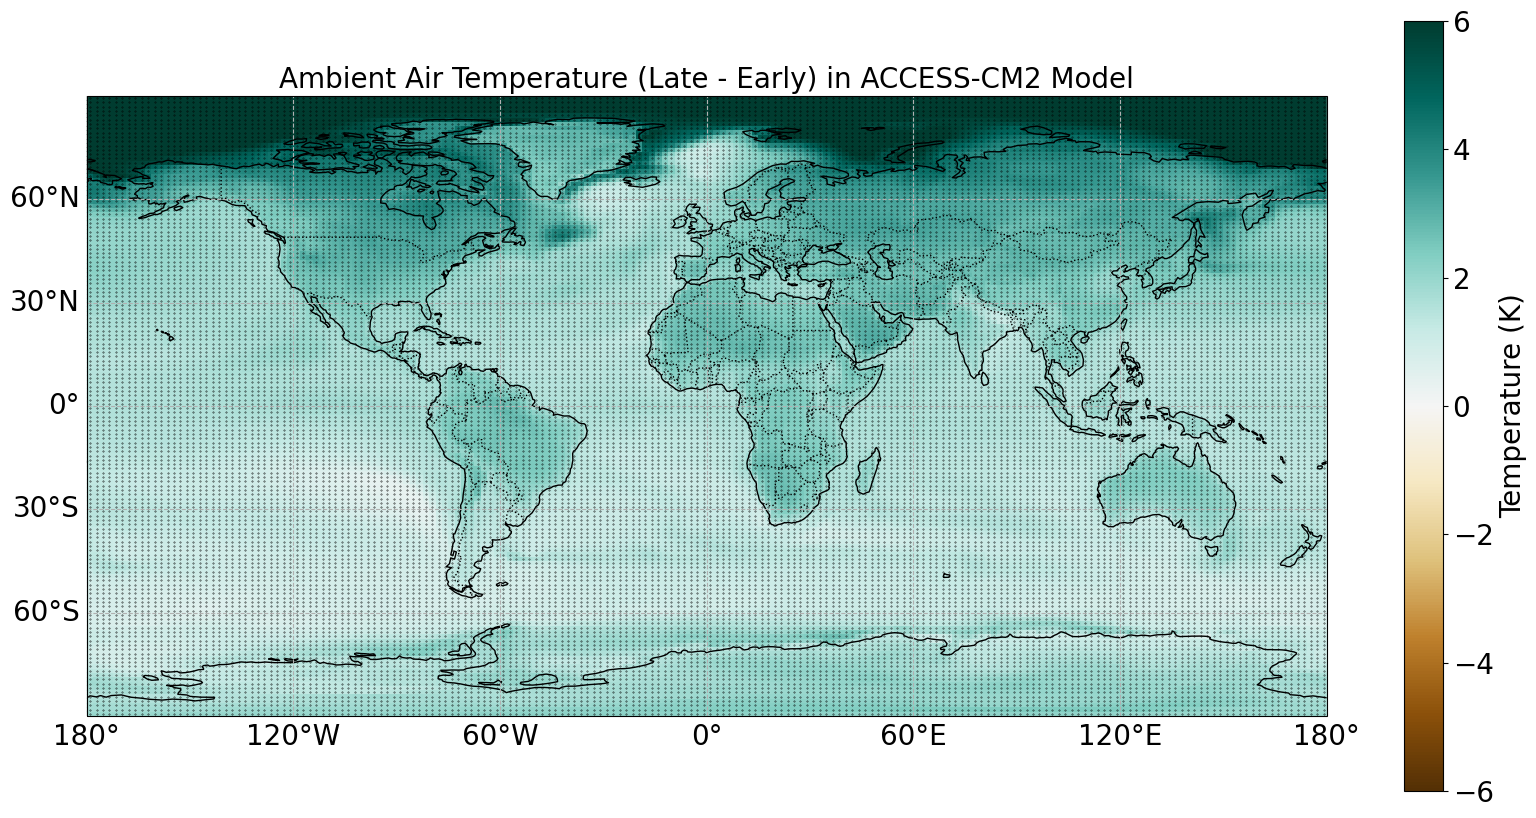

In [14]:
# Calculate ensemble-mean epoch difference
ensmn_prdiff = pr_late.mean(axis=0) - pr_early.mean(axis=0)

# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": map})
# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(data_early_mn.lon, data_early_mn.lat, ensmn_prdiff, 
                     transform=map, cmap="BrBG", vmin=-6, vmax=6)

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Temperature (K)", fontsize=20)
cbar.ax.tick_params(labelsize=20)
# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")
# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False
gl.right_labels = False

# Set font size for x, y-axis labels
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}


# Statistical significance for historical vs future precip change regressed on gradient change
latitudes, longitudes = np.where(pr_pvals_rs < 0.05)
lats = data_early_mn.coords['lat'][latitudes].values
lons = data_early_mn.coords['lon'][longitudes].values
ax.scatter(lons, lats, color='black', s=0.1, transform=ccrs.PlateCarree())

# Add title, show plot
ax.set_title("Ambient Air Temperature (Late - Early) in ACCESS-CM2 Model", fontsize= 20)
plt.show()

In [ ]:
### Model 2 CESM2

In [ ]:
# Model 2. CESM2
# Make a list of the unique ensemble members
# historical
mems_hist = res_access_hist_2.df.member_id.unique()
# SSP
mems_ssp = res_access_ssp_2.df.member_id.unique()

# Convert these to sets, find the intersection between them, and convert back to a list
common_mems = list(set(mems_hist) & set(mems_ssp))

In [ ]:
# Define an empty list for output data
access_data = []

# Retrieve number of members the historical and SSP ensembles have in common
num = len(common_mems)

# Loop over all members-in-common
for mem in range(num):
    # Print statement to keep track of which member we're working on
    print(common_mems[mem])
    
    # Figure out where this member is in the historical ensemble
    # True/False array showing whether or not the member_id matches our member of interest
    hist_mask = res_access_hist_2.df['member_id'] == common_mems[mem]
    # extract (first) location where the mask is True
    hist_loc = res_access_hist_2.df['member_id'][hist_mask].index[0]
    
    # Do the same thing for the SSP ensemble
    ssp_mask = res_access_ssp_2.df['member_id'] == common_mems[mem]
    ssp_loc = res_access_ssp_2.df['member_id'][ssp_mask].index[0]
    
    # Extract data from each entry as xarray
    temp_data_hist = xr.open_zarr(res_access_hist_2.df['zstore'][hist_loc], storage_options={'anon': True})
    temp_data_ssp = xr.open_zarr(res_access_ssp_2.df['zstore'][ssp_loc], storage_options={'anon': True})
    
    # Concatenate the historical and SSP data across the time dimension
    temp_data = xr.concat([temp_data_hist, temp_data_ssp], dim="time")
    
    # Add the concatenated data to a list
    access_data.append(temp_data)

# Concatenate the list into a single xarray object
access_data = xr.concat(access_data, dim="member")

# Store the actual member information as values of the new dimension
access_data = access_data.assign_coords(member=("member", common_mems))

In [ ]:
# Print out units of tas data
access_data.tas.units

# Get data for an earlier period: 20th century
data_early = access_data.sel(time=slice("1970-01-01", "2020-12-31"))

# Get data for a later period: 21st century
data_late = access_data.sel(time=slice("2021-01-01", "2071-12-31"))

4a. Map the average over each time period separately

In [ ]:
# Take the time average for the CESM2 model
data_early_mn_2 = data_early_2.mean(dim="time")
data_late_mn_2 = data_late_2.mean(dim="time")

In [ ]:
# Extract the values into Numpy arrays for the CESM2 model
pr_early_2 = data_early_mn_2.tas.values
pr_late_2 = data_late_mn_2.tas.values

In [ ]:
# Define empty output arrays
# T-test
pr_pvals_t = np.empty((len(data_early_mn.lat), len(data_early_mn.lon)))
# Rank-sum test
pr_pvals_rs = np.empty((len(data_early_mn.lat), len(data_early_mn.lon)))

# Loop over lat, lon in the Numpy array
for latidx in range(len(data_early_mn.lat)):
    for lonidx in range(len(data_early_mn.lon)):
        # Run test on each grid point
        # T-test
        ttest = stats.ttest_ind(pr_early[:,latidx, lonidx], pr_late[:, latidx, lonidx])
        # Rank-sum
        stat_rs, pval_rs = stats.ranksums(pr_early[:,latidx, lonidx], pr_late[:, latidx, lonidx])
        
        # Save results in the output array
        pr_pvals_rs[latidx, lonidx] = pval_rs
        pr_pvals_t[latidx, lonidx] = ttest.pvalue

In [ ]:
# Calculate ensemble-mean epoch difference
ensmn_prdiff = pr_late.mean(axis=0) - pr_early.mean(axis=0)

# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": map})
# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(data_early_mn.lon, data_early_mn.lat, ensmn_prdiff, 
                     transform=map, cmap="BrBG", vmin=-6, vmax=6)

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Temperature (K)", fontsize=20)
cbar.ax.tick_params(labelsize=20)
# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")
# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False
gl.right_labels = False

# Set font size for x, y-axis labels
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}


# Statistical significance for historical vs future precip change regressed on gradient change
latitudes, longitudes = np.where(pr_pvals_rs < 0.05)
lats = data_early_mn.coords['lat'][latitudes].values
lons = data_early_mn.coords['lon'][longitudes].values
ax.scatter(lons, lats, color='black', s=0.1, transform=ccrs.PlateCarree())

# Add title, show plot
ax.set_title("Ambient Air Temperature (Late - Early) in ACCESS-CM2 Model", fontsize= 20)
plt.show()

4b. Map the difference in the averages between the two time periods (note: make sure to label which time period you subtracted from which!) For both your sets of maps, display some relevant political/geographic boundaries overlaid on the region: we saw some examples of how to do this using the Cartopy “feature” toolbox in the mapping tutorials

5. Write 1-2 paragraphs in markdown text describing the results of your plot, and what you
think they might mean for humans or ecosystems located in your study region.
To hand in the assignment, upload a PDF version of the notebook to Canvas, and include a link
to the URL for the notebook on Github (so I can find the code).
This assignment should be completed individually, but you’re free to collaborate and discuss
with classmates as you work. Just make sure that what you hand in is unique!